# Keras MNIST tutorial


## Contents

1. Load MNIST dataset
2. Check dataset
3. Convert to hot-one
4. Define model architecture
5. Fit model
6. Evaluate model
7. Visualise weights

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

import os    
os.environ['THEANO_FLAGS'] = "device=gpu0" 
import theano
print(theano.config.device)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
from keras import optimizers
from keras import callbacks
from keras import backend as K
from pylab import *
import gzip
import numpy as np
np.random.seed(123)  # for reproducibility

from __future__ import division

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:556: UserWarning: Theano flag device=gpu* (old gpu back-end) only support floatX=float32. You have floatX=float64. Use the new gpu back-end with device=cuda* for that value of floatX.
  warnings.warn(msg)
Using gpu device 0: GP10B (CNMeM is disabled, cuDNN 5110)


gpu0


Using Theano backend.


In [2]:
! pwd

/home/nvidia/keras/tutorials


### Load MNIST dataset

In [3]:
from urllib import urlretrieve

def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

# We then define functions for loading MNIST images and labels.
# For convenience, they also download the requested files if needed.

def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    # Read the inputs in Yann LeCun's binary format.
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    # The inputs are vectors now, we reshape them to monochrome 2D images,
    # following the shape convention: (examples, channels, rows, columns)
    data = data.reshape(-1, 1, 28, 28)
    # The inputs come as bytes, we convert them to float32 in range [0,1].
    # (Actually to range [0, 255/256], for compatibility to the version
    # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
    return data / np.float32(256)

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    # Read the labels in Yann LeCun's binary format.
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    # The labels are vectors of integers now, that's exactly what we want.
    return data

In [4]:
X_train = load_mnist_images('train-images-idx3-ubyte.gz')
y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

### Check dataset

In [5]:
print X_train.shape
print y_train.shape
print X_test.shape
print y_test.shape

(60000, 1, 28, 28)
(60000,)
(10000, 1, 28, 28)
(10000,)


0.996094


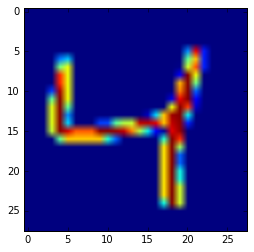

In [6]:
plt.imshow(X_train[2][0])
print np.amax(X_train[2][0])

In [7]:
print X_train.shape
print X_test.shape

(60000, 1, 28, 28)
(10000, 1, 28, 28)


In [8]:
# Convert to float32 and normalise to range [0,1]
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
#X_train /= 255
#X_test /= 255

## Convert labels to 10 distinct class labels (one-hot)

In [9]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [10]:
print Y_train.shape
print y_train[:2]
print Y_train[:2]

(60000, 10)
[5 0]
[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


# 4. Define model architecture

In [160]:
model = Sequential()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [161]:
model.add(Conv2D(32, (3, 3), data_format="channels_first",activation='tanh',input_shape=(1,28,28)))
model.add(Conv2D(32, (3, 3)))
layer_2 = Activation('relu')
model.add(layer_2)
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

In [162]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 26, 26)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 24, 32)        7520      
_________________________________________________________________
activation_3 (Activation)    (None, 30, 24, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 12, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 5760)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5760)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                57610     
Total para

In [163]:
adm = optimizers.Adam(lr=0.01, decay=0.0005)
sgd = optimizers.SGD(lr=0.01, momentum=0.09, decay=0.0005, nesterov=False)
model.compile(loss='categorical_crossentropy',
              optimizer=adm, metrics=['accuracy'])

In [168]:
class NBatchLogger(callbacks.Callback):
    def __init__(self,display=100):
        '''
        display: Number of batches to wait before outputting loss
        '''
        self.seen = 0
        self.display = display
        self.acc_train = []
        self.loss_train = []
        self.samples = []       # array to keep number of seen samples at log points 
        self.epoch_samples = [] # array to keep number of seen samples at epochs start (validation points)
        self.log_points = 0
        self.acc_accum = 0
        self.loss_accum = 0
        self.average_samples = 0  # Number of samples to use for avaraging acc and loss
        self.batch = 0 # last logs['batch'] number. When it decreases means a new epoch started
        self.epoch = 0 # epochs counter

    def on_batch_end(self,batch,logs={}):
        self.seen += logs.get('size', 0)
        self.average_samples += 1
        #print logs
        #print self.params        
        self.acc_accum += logs['acc']
        self.loss_accum += logs['loss']
        # Check new epoch start – it will be validation point
        if self.batch > logs['batch']:
            # New epoch start
            self.epoch += 1
            print "Epoch",self.epoch,"samples", self.params['samples'], "acc:",self.acc_accum/self.average_samples, \
                "loss:",self.loss_accum/self.average_samples
            self.batch = 0
            self.epoch_samples.append(self.seen - self.params['samples']/2) # "minus" to center epoch points on averaging area on x-axis
        else:
            self.batch = logs['batch']
        if self.seen == self.params['samples']*self.params['epochs']:
            # Last sample
            print "Last batch"
            self.epoch_samples.append(self.seen - self.params['samples']/2)            
        #print "batch:",logs['batch'],logs['batch']%self.display," seen:",self.seen
        if logs['batch'] % self.display == 0:  
            self.acc_train.append(self.acc_accum/self.average_samples)
            self.loss_train.append(self.loss_accum/self.average_samples)
            self.samples.append(self.seen)
            self.average_samples = 0
            self.log_points += 1
            self.acc_accum = 0
            self.loss_accum = 0
            #print '{0}/{1} batch:{4} acc: {2} Loss: {3}'.format(self.seen,self.params['samples']*self.params['epochs'], logs['acc'],logs['loss'],logs['batch'])

In [169]:
class BatchHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accurs = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accurs.append(logs.get('acc'))

# 5. Fit model on training data

In [170]:
samples = 60000 # batches to see in one epoch
batch_train_history = NBatchLogger(display=10)
print "using "+str(samples)+" samples"
history = model.fit(X_train[:samples], Y_train[:samples], validation_data=(X_test,Y_test), \
                      batch_size=64, epochs=10, verbose=0, callbacks=[batch_train_history])


using 60000 samples
Epoch 1 samples 60000 acc: 0.95703125 loss: 0.141545285471
Epoch 2 samples 60000 acc: 0.98046875 loss: 0.068906150409
Epoch 3 samples 60000 acc: 0.98828125 loss: 0.0262740451726
Epoch 4 samples 60000 acc: 0.982421875 loss: 0.0550393294543
Epoch 5 samples 60000 acc: 0.994140625 loss: 0.00900373877084
Epoch 6 samples 60000 acc: 0.984375 loss: 0.0562267337009
Epoch 7 samples 60000 acc: 0.98828125 loss: 0.0511382246332
Epoch 8 samples 60000 acc: 0.998046875 loss: 0.0101264744299
Epoch 9 samples 60000 acc: 0.994140625 loss: 0.0148441136434
Last batch


In [175]:
def plot_loss_accuracy(train_loss, test_loss, train_acc, test_acc, test_points, validation_points) :    
    fig = plt.figure(figsize=(15, 10))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    ax1.plot(test_points, train_loss, 'r-',label= "loss_train",alpha=0.3)
    ax1.plot(validation_points, test_loss, 'r.-',label= "loss_test")
    ax2.plot(test_points, train_acc, 'b-',label= "acc_train",alpha=0.7)
    ax2.plot(validation_points, test_acc, 'b.-',label= "acc_test")
    ax1.set_ylim([0,2.5])
    ax1.set_xlabel('batch')
    ax1.set_ylabel('loss')
    ax2.set_ylabel('accuracy')

    ax2.set_ylim([0,1])
    ax1.legend(loc='center right')
    ax2.legend(loc='best')
    ax1.minorticks_on()
    ax1.grid(which="both")

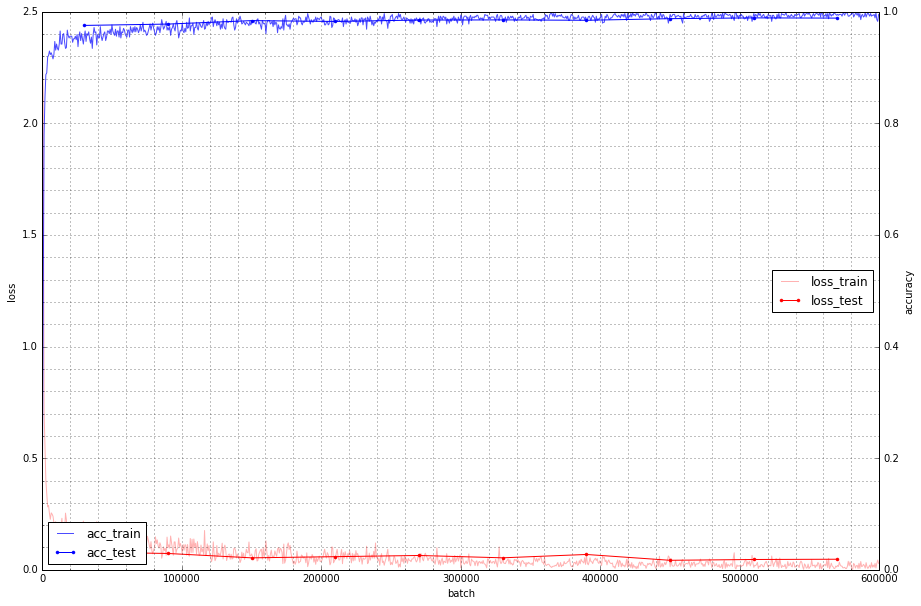

In [176]:
plot_loss_accuracy(batch_train_history.loss_train, history.history['val_loss'], \
                   batch_train_history.acc_train,  history.history['val_acc'], batch_train_history.samples, batch_train_history.epoch_samples )   

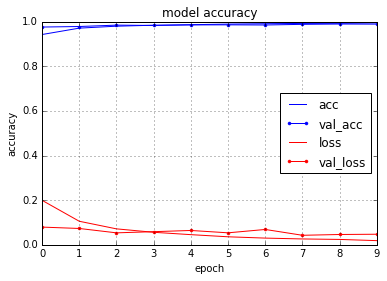

In [177]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'],'b.-')
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'r.-')
axes = plt.gca()
#axes.set_ylim([0,1.1])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc','val_acc', 'loss','val_loss'], loc='center right')
plt.grid()
plt.show()

# 6. Evaluate model on test data

In [178]:
score = model.evaluate(X_test, Y_test, verbose=1)
print score

 9984/10000 [============================>.] - ETA: 0s ETA: [0.047340124724474575, 0.98870000000000002]


### Performance:
```
SGD  64 x 10 : [0.12845374414473773, 0.96179999999999999]
Adam 64 x 10 : [0.047340124724474575, 0.98870000000000002]
```

# 7. Visualise weights

In [ ]:
# utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    plt.colorbar(im, cax=cax)

In [ ]:
import numpy.ma as ma
def make_mosaic(imgs, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    dims = len(imgs.shape)
    if dims > 3:
        # Squash last dimentions
        print "Array has ",dims," dimensions"
        last_dim_shape = 1
        for d in range(2,dims):
            last_dim_shape *= imgs.shape[d]
        imgs = np.reshape(imgs,(imgs.shape[0],imgs.shape[1], last_dim_shape))
        print "New shape ", imgs.shape
        
    nimgs = imgs.shape[2]
    imshape = imgs.shape[:2]
    print nimgs, "images, shaped:",imshape 
    srt = math.sqrt(nimgs)
    nrows = int(math.floor(srt))
    ncols = nimgs // nrows + 1
    print nrows, "x", ncols
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in xrange(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[:,:,i]
    return mosaic

In [ ]:
def show_weights(model, layer, layer_name):
    #layer_f = K.function(model.inputs, [layer.output])

    # Visualize weights
    W = model.layers[layer].kernel.get_value(borrow=True)
    W = np.squeeze(W)
    print("W shape : ", W.shape)

    plt.figure(figsize=(10, 10))
    plt.title(layer_name+' weights')
    nice_imshow(plt.gca(), make_mosaic(W), cmap=cm.binary)

In [ ]:
show_weights(model, 0, "Layer 0")

In [ ]:
show_weights(model, 1, "Layer 1")